In [134]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

### Web Scraping

In [135]:
# scrape the airline website

base_url = "https://www.airlinequality.com/airline-reviews/british-airways"

df = pd.DataFrame(columns=['text','aircraft','traveller_type','seat_type','route','date_flown','rec'])

pages_scraped = 10
reviews_per_page = 100

for page in range(1, pages_scraped+1):

    page_url = f"{base_url}/page/{page}/?sortby=post_date%3ADesc&pagesize={reviews_per_page}"

    response = requests.get(page_url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    for full_review in parsed_content.find_all("div", {"class": "tc_mobile"}):
        
        # first find the component with the corresponding class. the text we want is 
        # in the component that follows that one
        text = full_review.find("div", {"class": "text_content"}).get_text()
        aircraft = full_review.find("td", {"class": "aircraft"}).find_next().get_text() if full_review.find("td", {"class": "aircraft"}) else None
        traveller_type = full_review.find("td", {"class": "type_of_traveller"}).find_next().get_text() if full_review.find("td", {"class": "type_of_traveller"}) else None
        seat_type = full_review.find("td", {"class": "cabin_flown"}).find_next().get_text() if full_review.find("td", {"class": "cabin_flown"}) else None
        route = full_review.find("td", {"class": "route"}).find_next().get_text() if full_review.find("td", {"class": "route"}) else None
        date_flown = full_review.find("td", {"class": "date_flown"}).find_next().get_text() if full_review.find("td", {"class": "date_flown"}) else None
        rec = full_review.find("td", {"class": "recommended"}).find_next().get_text() if full_review.find("td", {"class": "recommended"}) else None

        df.loc[len(df)] = [text, aircraft, traveller_type, seat_type, route, date_flown, rec]

df.head()

,text,aircraft,traveller_type,seat_type,route,date_flown,rec
0,✅ Trip Verified | Boarding was difficult caus...,A320,Solo Leisure,Business Class,London Heathrow to Brussels,March 2024,yes
1,✅ Trip Verified | Boarding started with a del...,Boeing 777,Solo Leisure,Business Class,Barbados to London heathrow,March 2024,no
2,✅ Trip Verified | Absolutely horrible custome...,None,Family Leisure,Economy Class,Toronto to Mumbai via London,February 2024,no
3,Not Verified | BA is not what it used to be! ...,None,Family Leisure,Economy Class,Copenhagen to Port of Spain via London,February 2024,yes
4,"✅ Trip Verified | BA First, it's not even the...",Boeing 777-300ER,Solo Leisure,First Class,Los Angeles to London,March 2024,no


In [136]:
# split the text column into two columns, one with the text that only includes the review text (without
# the "verified" text), and another with "verified" as a boolean
  
split_df = pd.DataFrame()
split_df[["verified", "text"]] = df['text'].str.split('|', n=1, expand=True)
split_df["verified"] = np.where(split_df["verified"].str.contains("Not"), False, True)

df.drop(columns=['text'], inplace=True)
df = pd.concat([df, split_df], axis=1)
df

,aircraft,traveller_type,seat_type,route,date_flown,rec,verified,text
0,A320,Solo Leisure,Business Class,London Heathrow to Brussels,March 2024,yes,True,Boarding was difficult caused by vast majori...
1,Boeing 777,Solo Leisure,Business Class,Barbados to London heathrow,March 2024,no,True,Boarding started with a delay of some 20 min...
2,None,Family Leisure,Economy Class,Toronto to Mumbai via London,February 2024,no,True,Absolutely horrible customer service - will ...
3,None,Family Leisure,Economy Class,Copenhagen to Port of Spain via London,February 2024,yes,False,BA is not what it used to be! As much as I l...
4,Boeing 777-300ER,Solo Leisure,First Class,Los Angeles to London,March 2024,no,True,"BA First, it's not even the best business cl..."
...,...,...,...,...,...,...,...,...
995,Boeing 747-400,Solo Leisure,Economy Class,London to Vancouver,March 2019,yes,True,London to Vancouver. Check in agent very hel...
996,Boeing 777,Solo Leisure,First Class,London to Mumbai,March 2019,yes,True,The First Class zone at Heathrow T5 and the C...
997,Boeing 777,Business,First Class,London to Chicago,March 2019,no,True,I had a miserable experience in first class ...
998,None,Solo Leisure,Economy Class,Leeds Bradford to Las Vegas via Heathrow,September 2018,yes,True,Leeds Bradford to Las Vegas via Heathrow. Cu...


In [137]:
# split the route column into two columns, one with the origin and one with the destination
  
split_df = pd.DataFrame()
split_df[["origin", "dest"]] = df['route'].str.split('to', n=1, expand=True)

df.drop(columns=['route'], inplace=True)
df = pd.concat([df, split_df], axis=1)
df

,aircraft,traveller_type,seat_type,date_flown,rec,verified,text,origin,dest
0,A320,Solo Leisure,Business Class,March 2024,yes,True,Boarding was difficult caused by vast majori...,London Heathrow,Brussels
1,Boeing 777,Solo Leisure,Business Class,March 2024,no,True,Boarding started with a delay of some 20 min...,Barbados,London heathrow
2,None,Family Leisure,Economy Class,February 2024,no,True,Absolutely horrible customer service - will ...,Toron,to Mumbai via London
3,None,Family Leisure,Economy Class,February 2024,yes,False,BA is not what it used to be! As much as I l...,Copenhagen,Port of Spain via London
4,Boeing 777-300ER,Solo Leisure,First Class,March 2024,no,True,"BA First, it's not even the best business cl...",Los Angeles,London
...,...,...,...,...,...,...,...,...,...
995,Boeing 747-400,Solo Leisure,Economy Class,March 2019,yes,True,London to Vancouver. Check in agent very hel...,London,Vancouver
996,Boeing 777,Solo Leisure,First Class,March 2019,yes,True,The First Class zone at Heathrow T5 and the C...,London,Mumbai
997,Boeing 777,Business,First Class,March 2019,no,True,I had a miserable experience in first class ...,London,Chicago
998,None,Solo Leisure,Economy Class,September 2018,yes,True,Leeds Bradford to Las Vegas via Heathrow. Cu...,Leeds Bradford,Las Vegas via Heathrow


### Sentiment Analysis

In [138]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [139]:
m_name =  f"distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(m_name)
m = AutoModelForSequenceClassification.from_pretrained(m_name)
classifier = pipeline("sentiment-analysis", model=m, tokenizer=tokenizer)

In [140]:
# iternate through all of the reviews and make a dataframe containing the sentiments of each review
sent_df = pd.DataFrame(columns=['sentiment_label', 'sentiment_score'])

for index, row in df.iterrows():
    text = row['text'][:512] # truncating the string to 512 chars. This is the limit for the model
    result = classifier(text) # classifier returns a list of length 1 containing a dict with two keys ('label' and 'score')
    sent_df.loc[len(sent_df)] = [result[0]['label'], result[0]['score']] 

sent_df.head()

,sentiment_label,sentiment_score
0,NEGATIVE,0.968747
1,NEGATIVE,0.995446
2,NEGATIVE,0.999461
3,NEGATIVE,0.996025
4,NEGATIVE,0.999621


In [141]:
# add this new df to our original df. now we have a df where we know the sentiment of all the review! 
df = pd.concat([df, sent_df], axis=1)
df.head()

,aircraft,traveller_type,seat_type,date_flown,rec,verified,text,origin,dest,sentiment_label,sentiment_score
0,A320,Solo Leisure,Business Class,March 2024,yes,True,Boarding was difficult caused by vast majori...,London Heathrow,Brussels,NEGATIVE,0.968747
1,Boeing 777,Solo Leisure,Business Class,March 2024,no,True,Boarding started with a delay of some 20 min...,Barbados,London heathrow,NEGATIVE,0.995446
2,None,Family Leisure,Economy Class,February 2024,no,True,Absolutely horrible customer service - will ...,Toron,to Mumbai via London,NEGATIVE,0.999461
3,None,Family Leisure,Economy Class,February 2024,yes,False,BA is not what it used to be! As much as I l...,Copenhagen,Port of Spain via London,NEGATIVE,0.996025
4,Boeing 777-300ER,Solo Leisure,First Class,March 2024,no,True,"BA First, it's not even the best business cl...",Los Angeles,London,NEGATIVE,0.999621


### EDA

In [142]:
import matplotlib.pyplot as plt

In [ ]:
# getting a gist for flight frequencies

all_flights = df['origin']
flight_counts = all_flights.value_counts()

# Setting the figure size for better clarity
plt.figure(figsize=(8, len(flight_counts) * 0.2))  # Adjust the second parameter as needed

plt.barh(flight_counts.index, flight_counts)

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Flight Origin')
plt.title('Count of Flight Frequencies')

plt.show()



# getting a gist of aircraft frequency

all_aircrafts = df['aircraft']
aircraft_counts = all_aircrafts.value_counts()

# Setting the figure size for better clarity
plt.figure(figsize=(8, len(aircraft_counts) * 0.2))  # Adjust the second parameter as needed

plt.barh(aircraft_counts.index, aircraft_counts)

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Aircraft')
plt.title('Aircraft Usage Frequencies')

plt.show()

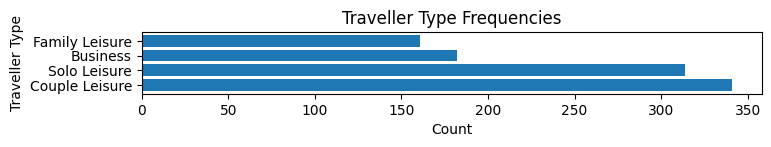

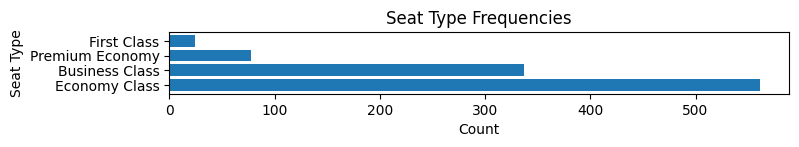

In [155]:
# getting a gist of traveller types

travellers = df['traveller_type']
traveller_type_counts = travellers.value_counts()

# Setting the figure size for better clarity
plt.figure(figsize=(8, len(traveller_type_counts) * 0.2))  # Adjust the second parameter as needed

plt.barh(traveller_type_counts.index, traveller_type_counts)

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Traveller Type')
plt.title('Traveller Type Frequencies')

plt.show()


# getting a gist of seat types

seats = df['seat_type']
seat_type_counts = seats.value_counts()

# Setting the figure size for better clarity
plt.figure(figsize=(8, len(seat_type_counts) * 0.2))  # Adjust the second parameter as needed

plt.barh(seat_type_counts.index, seat_type_counts)

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Seat Type')
plt.title('Seat Type Frequencies')

plt.show()

In [179]:
# positive sentiment percentage for each seat type

for seat in df['seat_type'].unique():

    bad = len(df.query(f'seat_type == "{seat}" and sentiment_label == "NEGATIVE"'))
    print(f"Number of people in {seat} with bad sentiment: {bad}")

    good = len(df.query(f'seat_type == "{seat}" and sentiment_label == "POSITIVE"'))
    print(f"Number of people in {seat} with good sentiment: {good}")

    print(f"Percentage of people in {seat} with good sentiment: {(good/(good+bad)) * 100:.0f}%\n")

Number of people in Business Class with bad sentiment: 226
Number of people in Business Class with good sentiment: 111
Percentage of people in Business Class with good sentiment: 33%

Number of people in Economy Class with bad sentiment: 449
Number of people in Economy Class with good sentiment: 112
Percentage of people in Economy Class with good sentiment: 20%

Number of people in First Class with bad sentiment: 13
Number of people in First Class with good sentiment: 11
Percentage of people in First Class with good sentiment: 46%

Number of people in Premium Economy with bad sentiment: 62
Number of people in Premium Economy with good sentiment: 16
Percentage of people in Premium Economy with good sentiment: 21%



In [ ]:
# TODO: Summarize per seat type, per origin, per traveller type, per aircraft flown, and per month/year